In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import pytorch_lightning as pl
import evoaug
from evoaug import evoaug, augment
from evoaug_analysis import utils, model_zoo
import help_func
import h5py
import glob
import pandas as pd

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

/home/peter/torch/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Model

In [2]:
# load checkpoint for model with best validation performance
ckpt_aug_path ='./model/DeepSTARR_combo1_finetune_2.ckpt'

deepstarr = model_zoo.DeepSTARR(2)
loss = torch.nn.MSELoss()
optimizer_dict = utils.configure_optimizer(deepstarr, lr=0.001, weight_decay=1e-6, decay_factor=0.1, patience=5, monitor='val_loss')

augment_list = [
    augment.RandomDeletion(delete_min=0, delete_max=30),
    augment.RandomInsertion(insert_min=0, insert_max=20),
    augment.RandomTranslocation(shift_min=0, shift_max=20),
    augment.RandomNoise(noise_mean=0, noise_std=0.3),
    augment.RandomMutation(mutate_frac=0.05),
]
robust_cnn = evoaug.RobustModel(deepstarr,
                                criterion=loss,
                                optimizer=optimizer_dict,
                                augment_list=augment_list,
                                max_augs_per_seq=2,
                                hard_aug=True,
                                finetune=False,
                                inference_aug=False)

# load model weights
robust_cnn = evoaug.load_model_from_checkpoint(robust_cnn, ckpt_aug_path)
robust_cnn.eval()

/home/peter/torch/lib/python3.8/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/home/peter/torch/lib/python3.8/site-packages/pytorch_lightning/core/lightning.py:22: LightningDeprecationWarning: pytorch_lightning.core.lightning.LightningModule has been deprecated in v1.7 and will be removed in v1.9. Use the equivalent class from the pytorch_lightning.core.module.LightningModule class instead.
  rank_zero_deprecation(


RobustModel(
  (model): DeepSTARR(
    (activation): ReLU()
    (dropout4): Dropout(p=0.4, inplace=False)
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (batchnorm1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation1): ReLU()
    (maxpool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (batchnorm2): BatchNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (maxpool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (batchnorm3): BatchNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (maxpool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (batchnorm4): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (maxpool4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (fc5): LazyLinear(in_features=0, out_features=256, bias=Tr

## SHAP score calculation

In [3]:
class_index = 1

In [4]:
# load ground truth data
datafile = ('./dataset/DeepSTARR_data.h5')
dataset = h5py.File(datafile, 'r')
x_test = np.array(dataset['X_test']).astype(np.float32)
y_test = np.array(dataset['Y_test']).astype(np.float32)

# select high activity sequences
num_plot = 1000
act_idx = np.argsort(y_test[:,class_index])[-num_plot:]
act_x = x_test[act_idx]
np.savez('./attr_analysis/saliency_seq/STAR_gt_ci%d.npz'%class_index,act_x)

## Dinuc shuffle baseline

In [5]:
#reproducibility seed 
np.random.seed(0)
shuffle_seq = []
for seq in x_test:
    shuffle_seq.append(help_func.dinuc_shuffle(seq))
shuffle_seq = np.swapaxes(shuffle_seq,1,2)
np.savez('./dataset/DeepSTARR_test_gen_dinuc_shuffle_ci_%d.npz'%class_index,shuffle_seq)

## Ground Truth SHAP score

In [6]:
help_func.gradient_shap(act_x,act_idx,num_plot,robust_cnn,class_index,save_score='./attr_analysis/saliency_score/STAR_gt_ci%d.npz'%class_index)
# help_func.gradient_shap(act_x,act_idx,num_plot,robust_cnn,class_index,
#                         title='Ground Truth STARR-seq',save_dir='./attr_analysis/gt_ci%d.pdf'%class_index)

## SHAP score for all generated seq

In [7]:
for dataset in glob.glob('./dataset/*.npz'):
    dataset_name = dataset.split('/')[-1].split('_')
    dataset_name = dataset_name[3] + '_' + dataset_name[4]
    x = np.load(dataset)['arr_0']
    act_x = np.swapaxes(x[act_idx],1,2)
    np.savez('./attr_analysis/saliency_seq/'+dataset_name+'_ci%d.npz'%class_index,act_x)
    help_func.gradient_shap(act_x,act_idx,num_plot,robust_cnn,class_index,
                            save_score='./attr_analysis/saliency_score/'+dataset_name+'_ci%d.npz'%class_index)
#     help_func.gradient_shap(act_x,act_idx,num_plot,robust_cnn,class_index, 
#                            title=dataset_name,save_dir='./attr_analysis/'+dataset_name+'_ci1.pdf')

## SHAP score for fixed label experiment

In [3]:
class_index = 0
num_plot = 500
act_idx = 21106

# load ground truth data
datafile = ('./dataset/DeepSTARR_data.h5')
dataset = h5py.File(datafile, 'r')
x_test = np.array(dataset['X_test']).astype(np.float32)

# select high activity sequences
act_x = x_test[act_idx]
help_func.gradient_shap(np.array([act_x]),act_idx,1,
                        robust_cnn,class_index,
                        save_score='./attr_analysis/fix_label/STAR_gt_ci%d.npz'%class_index)

In [ ]:
## Shuffle ground truth seq for baseline
datafile = ('./dataset/DeepSTARR_data.h5')
dataset = h5py.File(datafile, 'r')
x_test = np.array(dataset['X_test']).astype(np.float32)

act_x = x_test[act_idx]
shuf_seq = help_func.dinuc_shuffle(np.swapaxes(act_x,0,1),num_shufs=num_plot)
#save shuffled seq
np.savez('./dataset/fix_label/DeepSTARR_dinuc_shuffle_test#21106_[7.0455,1.9738].npz',shuf_seq)

In [4]:
for dataset in glob.glob('./dataset/fix_label/*.npz'):
    dataset_name = dataset.split('/')[-1].split('_')
    act_idx = int(dataset_name[3].split('#')[-1])
    dataset_name = dataset_name[1] + '_' + dataset_name[2]+ '_' + dataset_name[3]
    x = np.load(dataset)['arr_0']
    x = np.swapaxes(x,1,2)
    help_func.gradient_shap(x,[act_idx]*num_plot,num_plot,robust_cnn,class_index,
                            save_score='./attr_analysis/fix_label/'+dataset_name+'_ci%d.npz'%class_index)

In [4]:
score_list = []
model_list = []

gt_saliency = np.load('./attr_analysis/fix_label/STAR_gt_ci1.npz')['arr_0'][0]
for dataset in glob.glob('./attr_analysis/fix_label/*test*.npz'):
    l2_list = []
    test_saliency = np.load(dataset)['arr_0']
    for sal in test_saliency:
        l2_dist = np.linalg.norm(sal - gt_saliency)
        l2_list.append(l2_dist)
    l2_sum_score = np.mean(l2_list)
    dataset_name = dataset.split('/')[-1].split('_')
    dataset_name = dataset_name[0] + '_' + dataset_name[1]
    model_list.append(dataset_name)
    score_list.append(l2_sum_score)
    
df = pd.DataFrame({'Model':model_list,'L2 Distance':score_list})
df.to_csv('./attr_analysis/fix_label/distance_summary.csv')
    

In [5]:
score_list = []
model_list = []

for dataset in glob.glob('./dataset/fix_label/*.npz'):
    x = np.load(dataset)['arr_0']
    x = np.swapaxes(x,1,2)
    N,A,L = x.shape
    id_score = np.sum(x*act_x)/L/N
    dataset_name = dataset.split('/')[-1].split('_')
    dataset_name = dataset_name[1] + '_' + dataset_name[2] 
    model_list.append(dataset_name)
    score_list.append(id_score)
    
df = pd.DataFrame({'Model':model_list,'Sequence Identity':score_list})
df.to_csv('./attr_analysis/fix_label/identity_summary.csv')    

In [5]:
import matplotlib.pyplot as plt

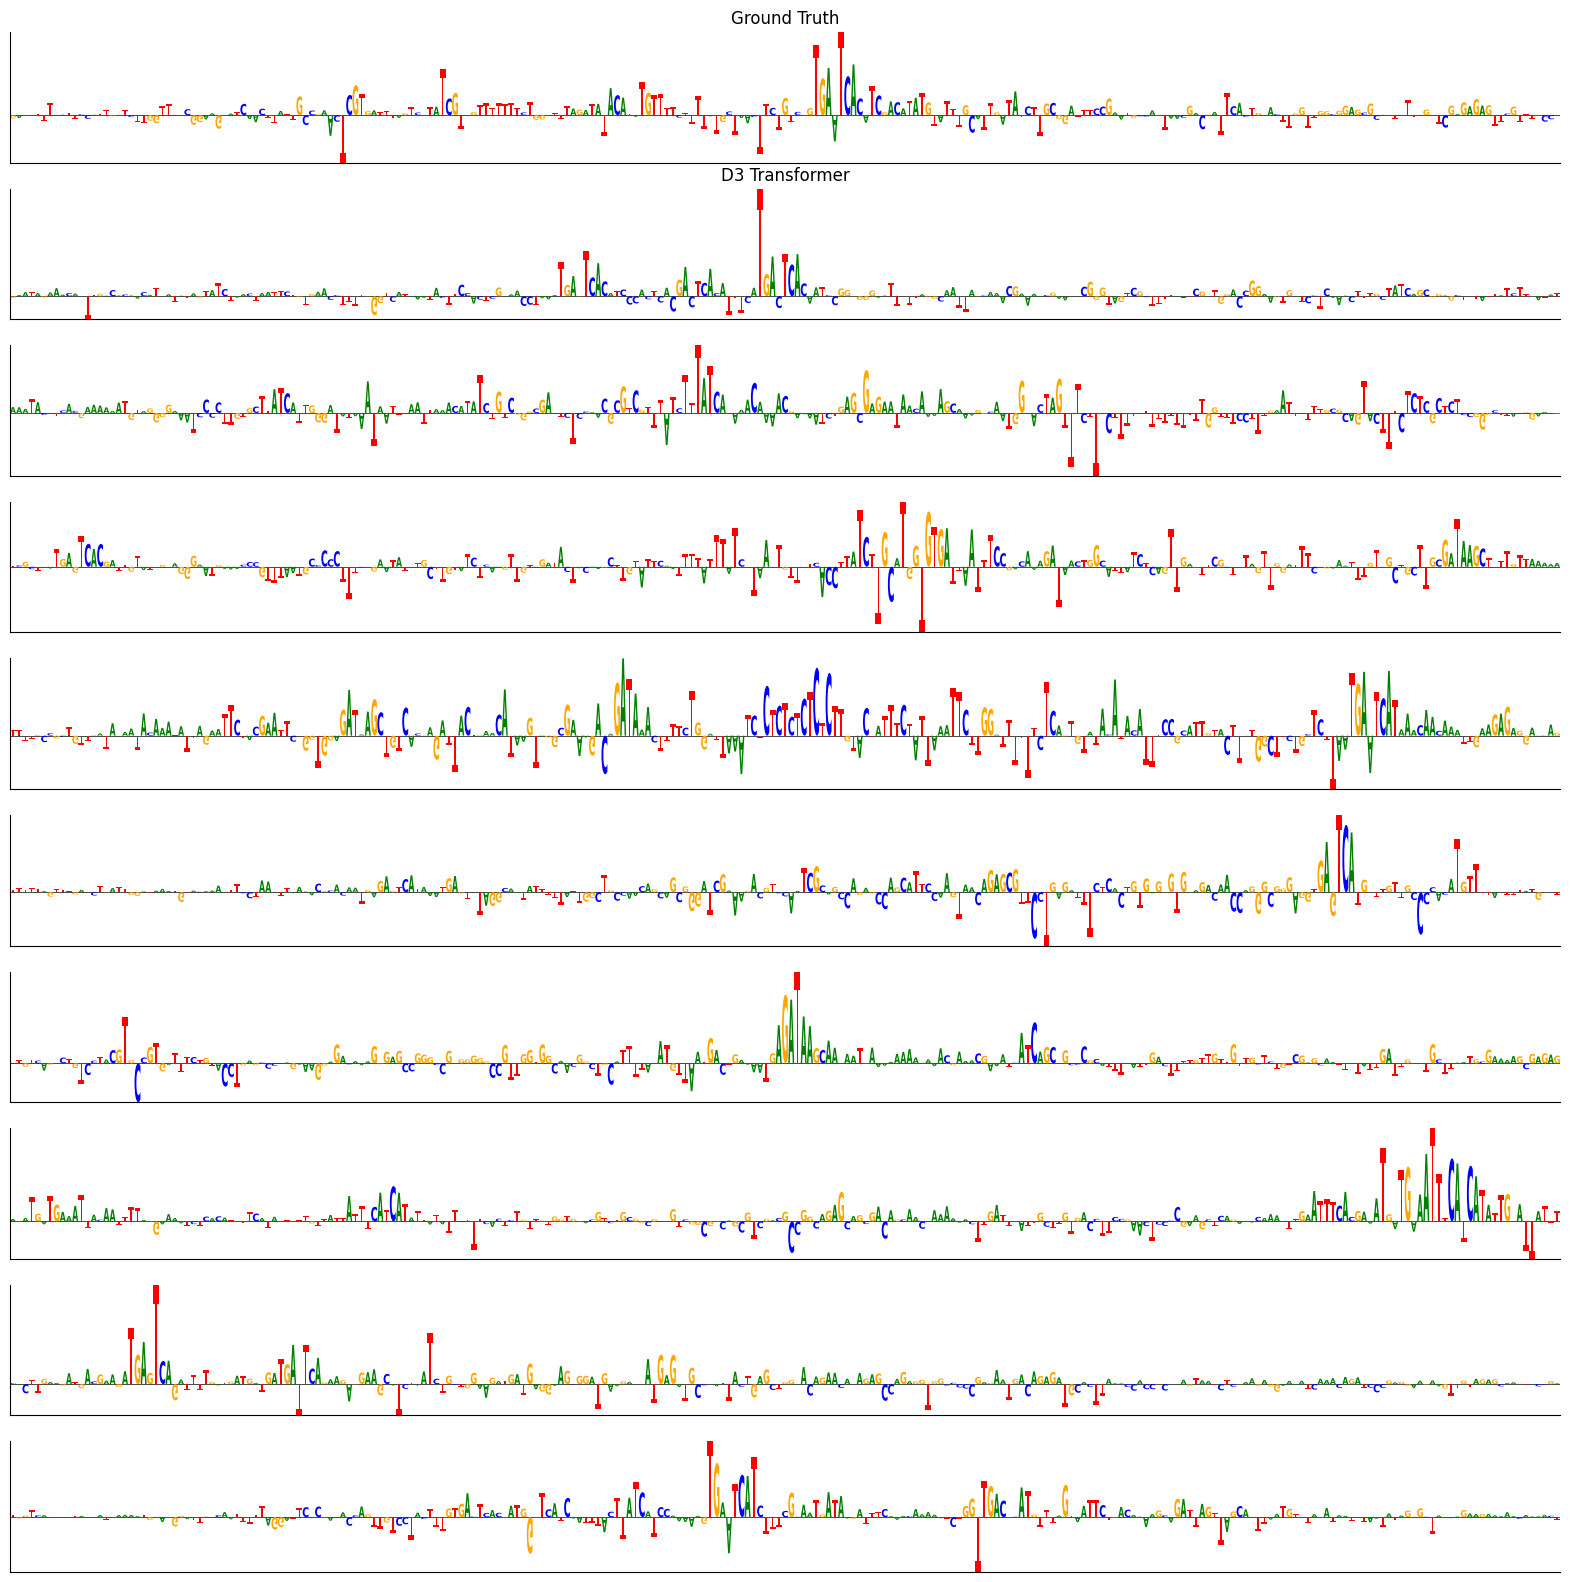

In [8]:
## plot
fig = plt.figure(figsize=(20,20))
saliency_gt = np.load('attr_analysis/fix_label/STAR_gt_ci1.npz')['arr_0']
datafile = ('./dataset/DeepSTARR_data.h5')
dataset = h5py.File(datafile, 'r')
x_test = np.array(dataset['X_test']).astype(np.float32)
x_gt = np.expand_dims(x_test[21106],0)
ax = plt.subplot(10,1,1)
saliency_df = help_func.grad_times_input_to_df(x_gt.transpose([0,2,1]), saliency_gt.transpose([0,2,1]))
help_func.plot_attribution_map(saliency_df, ax, figsize=(20,1))
ax.set_title('Ground Truth')


exp_saliency = np.load('attr_analysis/fix_label/sm_tran_test#21106_ci1.npz')['arr_0']
exp_seq = np.load('dataset/fix_label/DeepSTARR_sm_tran_test#21106_[7.0455,1.9738].npz')['arr_0']
for i in range(9):
    sal = exp_saliency[i]
    seq = exp_seq[i]
    ax = plt.subplot(10,1,i+2)
    saliency_df = help_func.grad_times_input_to_df(seq, sal.transpose([1,0]))
    help_func.plot_attribution_map(saliency_df, ax, figsize=(20,1))
    if i ==0:
        ax.set_title('D3 Transformer')
plt.savefig('attr_analysis/fix_label/fix_label_sm_tran_1.pdf')

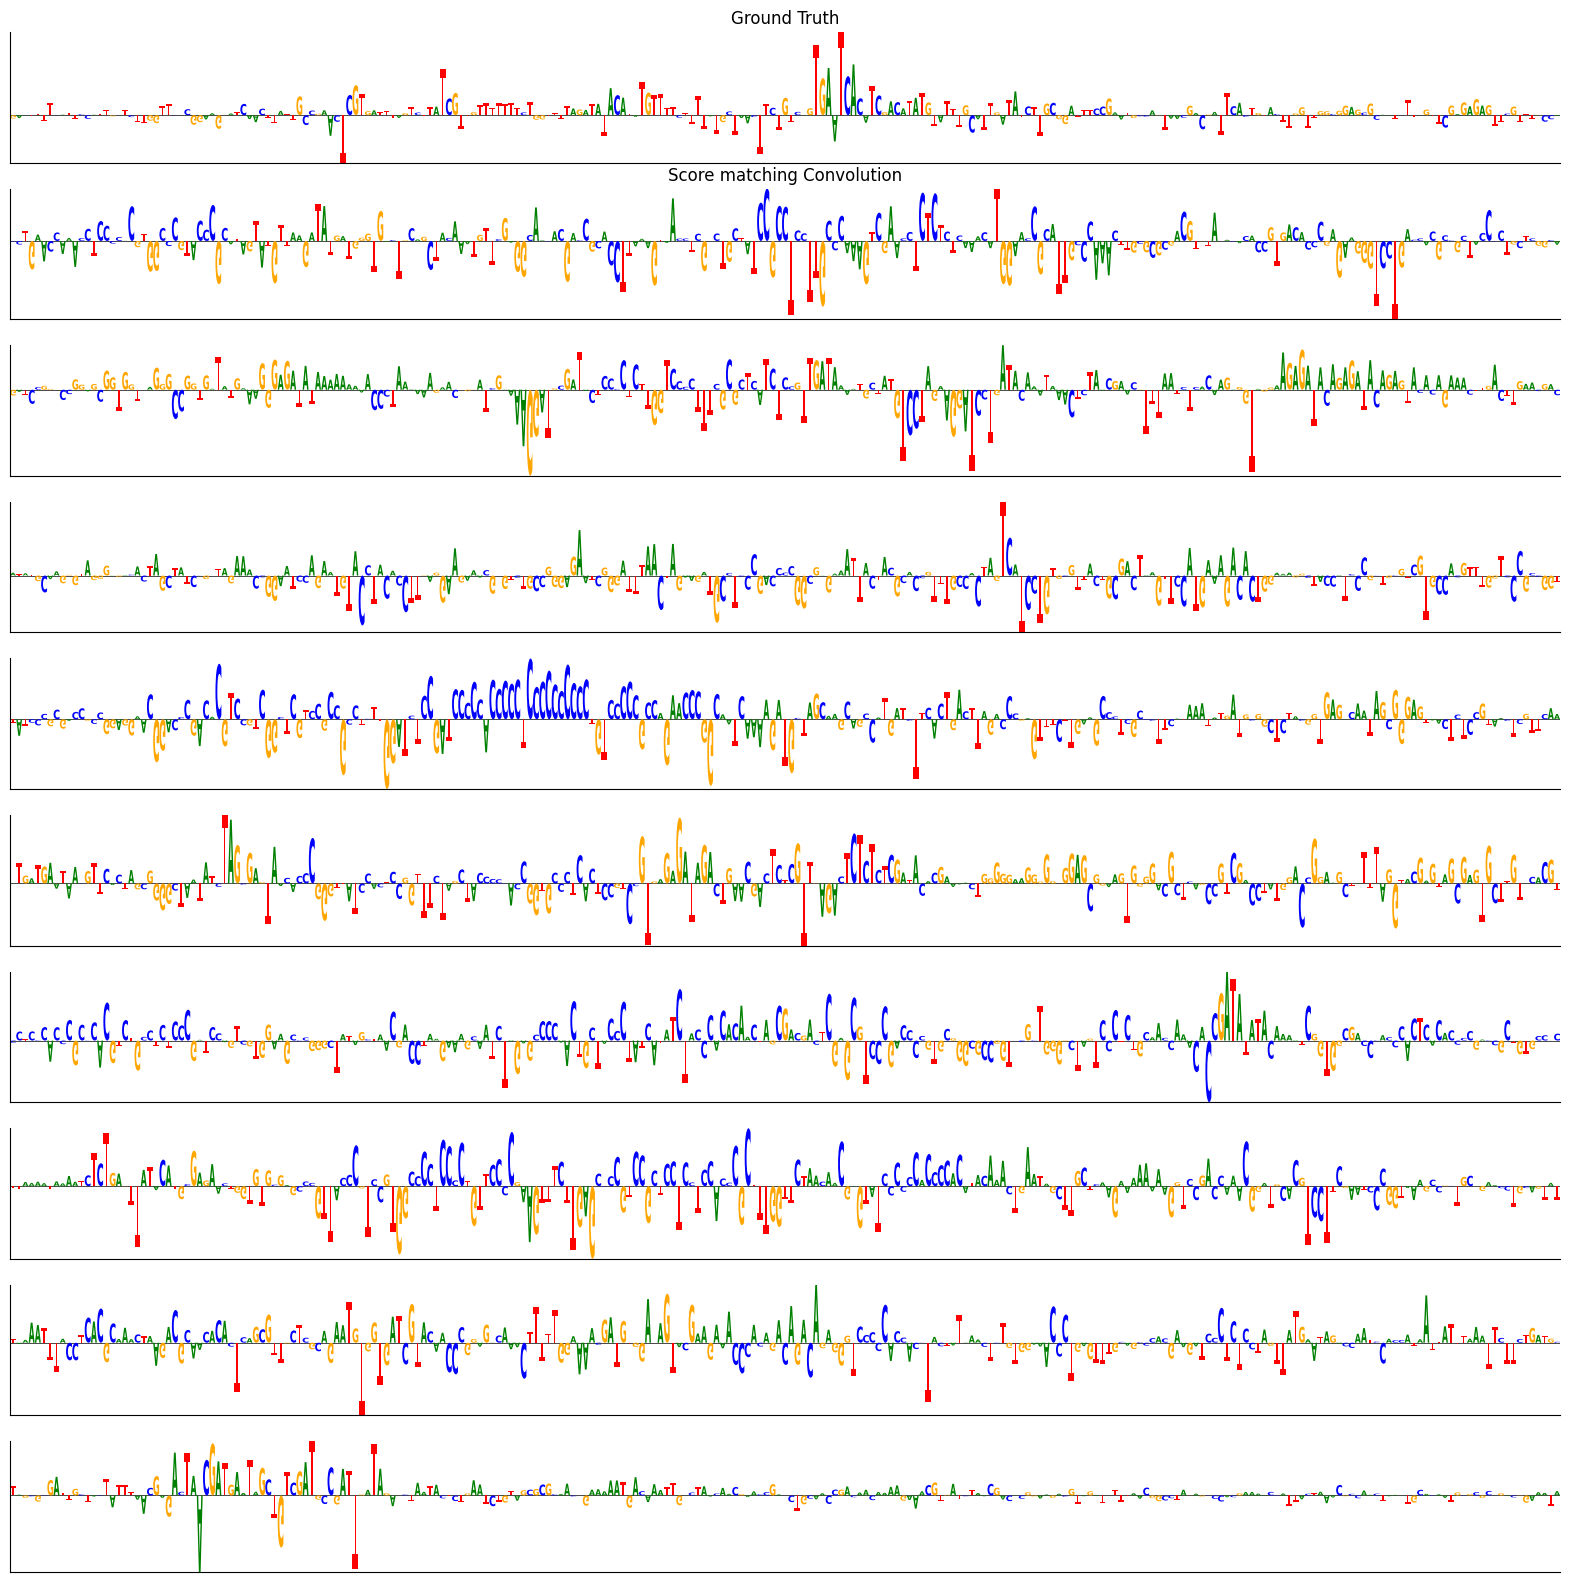

In [9]:
## plot
fig = plt.figure(figsize=(20,20))
saliency_gt = np.load('attr_analysis/fix_label/STAR_gt_ci1.npz')['arr_0']
datafile = ('./dataset/DeepSTARR_data.h5')
dataset = h5py.File(datafile, 'r')
x_test = np.array(dataset['X_test']).astype(np.float32)
x_gt = np.expand_dims(x_test[21106],0)
ax = plt.subplot(10,1,1)
saliency_df = help_func.grad_times_input_to_df(x_gt.transpose([0,2,1]), saliency_gt.transpose([0,2,1]))
help_func.plot_attribution_map(saliency_df, ax, figsize=(20,1))
ax.set_title('Ground Truth')


exp_saliency = np.load('attr_analysis/fix_label/fm_conv_test#21106_ci1.npz')['arr_0']
exp_seq = np.load('dataset/fix_label/DeepSTARR_fm_conv_test#21106_[7.0455,1.9738].npz')['arr_0']
for i in range(9):
    sal = exp_saliency[i]
    seq = exp_seq[i]
    ax = plt.subplot(10,1,i+2)
    saliency_df = help_func.grad_times_input_to_df(seq, sal.transpose([1,0]))
    help_func.plot_attribution_map(saliency_df, ax, figsize=(20,1))
    if i ==0:
        ax.set_title('Score matching Convolution')
plt.savefig('attr_analysis/fix_label/fix_label_fm_conv_1.pdf')

In [31]:
sal.shape

(4, 249)

In [32]:
x_gt.shape

(1, 4, 249)

In [33]:
saliency_gt.shape

(1, 4, 249)

In [3]:

shuf_seq = np.swapaxes(shuf_seq,1,2)
#save shap score
help_func.gradient_shap(shuf_seq,[act_idx]*num_plot,1,
                        robust_cnn,class_index,
                        save_score='./attr_analysis/fix_label/dinuc_shuffle_test#21106_ci%d.npz'%class_index)